In [1]:
import torch
torch.cuda.set_device(1)
from rsnautils import *
from fastai2.callback.data import *
from fastai2.medical.imaging  import *
from fastai2.basics import *

pd.options.display.max_rows = 999
set_num_threads(1)
nw = 8

In [2]:
qpath = Path('~/data/qure').expanduser()
meta = qpath/'meta'
meta.mkdir(exist_ok=True)

dest_path = qpath/'processed'
dest_path.mkdir(exist_ok=True)

In [3]:
dcm_files = L(qpath.glob('**/*.dcm'))
len(dcm_files)

171221

In [4]:
fn = dcm_files[0]
dcm = fn.dcmread()

In [5]:
def pd_read_sop_feather(fn):
    df = pd.read_feather(fn).set_index('SOPInstanceUID').sort_index()
    if 'index' in df.columns: df = df.drop('index', axis=1)
    return df

In [6]:
def save_qure_df():
    fn = meta/'qure.fth'
    if not fn.exists():
        print('building qure file')
        def diamater_clean(x):
            try: res = float(x)
            except: res = None
            return res

        df_dcms = pd.DataFrame.from_dicoms(dcm_files, px_summ=True, window=dicom_windows.brain, n_workers=12)
        df_dcms.ReconstructionDiameter = df_dcms.ReconstructionDiameter.apply(diamater_clean)
        df_dcms.ReferringPhysicianName = df_dcms.ReferringPhysicianName.astype(str)
        df_dcms.PatientName = df_dcms.PatientName.astype(str)
        df_dcms.DerivationCodeSequence = df_dcms.DerivationCodeSequence.astype(str)
        df_dcms.to_feather(meta/'qure.fth')
    print('qure files ready')

In [5]:
df_dcms = pd_read_sop_feather(meta/'qure.fth')

NameError: name 'pd_read_sop_feather' is not defined

In [8]:
boxes = pd.read_csv(qpath/'qureai-cq500-boxes-updated.csv')
probs = pd.read_csv(qpath/'prediction_probabilities.csv')
finfo = pd.read_csv(qpath/'cq500_files.txt')
reads = pd.read_csv(qpath/'reads.csv')

In [10]:
boxes.head()

,SOPInstanceUID,SeriesInstanceUID,StudyInstanceUID,data,labelName,number
0,1.2.276.0.7230010.3.1.4.296485376.1.1521713091.1722412,1.2.276.0.7230010.3.1.3.296485376.1.1521713090.1722057,1.2.276.0.7230010.3.1.2.296485376.1.1521713088.1721651,"{'x': 320.95899, 'y': 235.81072999999998, 'width': 30.68771, 'height': 52.4921}",Intraventricular,96
1,1.2.276.0.7230010.3.1.4.296485376.1.1521713091.1722416,1.2.276.0.7230010.3.1.3.296485376.1.1521713090.1722057,1.2.276.0.7230010.3.1.2.296485376.1.1521713088.1721651,"{'x': 320.95899, 'y': 235.81072999999998, 'width': 30.68771, 'height': 52.4921}",Intraventricular,96
2,1.2.276.0.7230010.3.1.4.296485376.1.1521713091.1722372,1.2.276.0.7230010.3.1.3.296485376.1.1521713090.1722057,1.2.276.0.7230010.3.1.2.296485376.1.1521713088.1721651,"{'x': 320.95899, 'y': 235.81072999999998, 'width': 30.68771, 'height': 52.4921}",Intraventricular,96
3,1.2.276.0.7230010.3.1.4.296485376.1.1521713091.1722384,1.2.276.0.7230010.3.1.3.296485376.1.1521713090.1722057,1.2.276.0.7230010.3.1.2.296485376.1.1521713088.1721651,"{'x': 320.95899, 'y': 235.81072999999998, 'width': 30.68771, 'height': 52.4921}",Intraventricular,96
4,1.2.276.0.7230010.3.1.4.296485376.1.1521713091.1722260,1.2.276.0.7230010.3.1.3.296485376.1.1521713090.1722057,1.2.276.0.7230010.3.1.2.296485376.1.1521713088.1721651,"{'x': 318.53628, 'y': 244.69401000000002, 'width': 33.91796, 'height': 56.52997}",Intraventricular,96


In [20]:
def save_qure_labels():
    fn = meta/'labels.fth'
    if not fn.exists():
        print('building label file')
        label_map = {
            'Subarachnoid': 'subarachnoid',
            'Subdural': 'subdural',
            'Epidural': 'epidural',
            'Intraparenchymal': 'intraparenchymal',
            'Intraventricular': 'intraventricular',
            'Chronic': 'chronic',
            #'Hand-drawn Series': 'handdrawn',
        }
        boxes['label'] = boxes.labelName.map(label_map)

        def box_data(x):
            try:    x = eval(x)
            except: x = {'x': None, 'y': None, 'width': None, 'height': None}
            return x

        data = pd.DataFrame(list(boxes.data.apply(box_data).values))
        data['volume'] = data.width * data.height

        box2 = pd.concat([boxes, data], axis=1)
        box2 = box2.loc[box2.data.notnull()].drop('data', axis=1)
        labels = (box2
                  .groupby(['SOPInstanceUID', 'label'])
                  .volume
                  .count()
                  .reset_index()
                  .drop_duplicates())
        labels = labels.pivot('SOPInstanceUID', columns='label').fillna(0).astype(bool).astype(int)
        labels.columns = [c[1] for c in labels.columns]

        labels['any'] = (labels.sum(axis=1)>0).astype(int)
        sops = df_dcms.index.unique()
        blank = [s for s in sops if s not in labels.index]
        labels = labels.reindex(labels.index.tolist() + blank).fillna(0.0).astype(bool).astype(int).reset_index()
        labels.to_feather(meta/'labels.fth')
    print('labels ready')

In [21]:
save_qure_labels()

building label file
labels ready


In [22]:
def save_qure_boxes():
    fn = meta/'boxes.fth'
    if not fn.exists():
        print('building bounds file')
        label_map = {
            'Subarachnoid': 'subarachnoid',
            'Subdural': 'subdural',
            'Epidural': 'epidural',
            'Intraparenchymal': 'intraparenchymal',
            'Intraventricular': 'intraventricular',
            'Chronic': 'chronic',
            #'Hand-drawn Series': 'handdrawn',
        }
        boxes['label'] = boxes.labelName.map(label_map)

        def box_data(x):
            try:    x = eval(x)
            except: x = {'x': None, 'y': None, 'width': None, 'height': None}
            return x

        data = pd.DataFrame(list(boxes.data.apply(box_data).values))
        data['volume'] = data.width * data.height
        
        box2 = pd.concat([boxes, data], axis=1)
        box2 = box2.loc[box2.data.notnull()].drop('data', axis=1)
        box_sort = box2.sort_values(['SOPInstanceUID', 'volume'], ascending=False)
        box_labels = box_sort.groupby(['SOPInstanceUID'])[['label','x','y', 'height', 'width','volume']].first()
        
        #set_trace()
        sops = list(df_dcms.index.unique())
        blank = [s for s in sops if s not in box_labels.index]
        box_labels = box_labels.reindex(box_labels.index.tolist() + blank)
        box_labels['label'] = box_labels.label.fillna('')
        box_labels = box_labels.fillna(0.0)
        box_labels.reset_index().to_feather(fn)
    print('boxes ready')

In [23]:
def save_combo():
    save_qure_df()
    df_dcms = pd_read_sop_feather(meta/'qure.fth')
    
    save_qure_labels()
    labels = pd_read_sop_feather(meta/'labels.fth')
    
    save_qure_boxes()
    box_labels = pd_read_sop_feather(meta/'boxes.fth')
    
    df_comb = pd.concat([df_dcms, labels, box_labels], axis=1)
    df_comb = add_pos(df_comb)
    df_comb.reset_index().to_feather(meta/'df_comb.fth')
    print('saved combo')

In [24]:
save_combo()

qure files ready
labels ready
building bounds file
boxes ready
saved combo


In [ ]:
df_comb = pd_read_sop_feather(meta/'df_comb.fth')

In [1]:
df_comb[df_comb.volume > 0].head(20)

NameError: name 'df_comb' is not defined

In [6]:
def dcm_fn(df,sop): return df.loc[sop, 'fname']

def surround_dcm(df, idx):
    rec = df.loc[idx]
    left,right = rec.Left,rec.Right
    dcm = dcm_tfm(dcm_fn(df,idx))
    if left != '': dcm_l = dcm_tfm(dcm_fn(df,left))
    else: dcm_l = torch.zeros_like(dcm)
    if right != '': dcm_r = dcm_tfm(dcm_fn(df,right))
    else: dcm_r = torch.zeros_like(dcm)
    return TensorCTScan(torch.stack([dcm,dcm_l,dcm_r]))

def surround2chans(dcms):
    dcm,dcm_l,dcm_r = dcms 
    t_l,t_r = dcm_l.hist_scaled(bins),dcm_r.hist_scaled(bins)
    return TensorCTScan(torch.cat([*dcm.to_3chan(*brain_wins, bins=bins), t_l, t_r]))

def surround2chans_tfm(dest_path, df, idx):
    o = surround_dcm(df, idx)
    res = (surround2chans(o)*(2**8-1)).byte()
    im = Image.fromarray(res.numpy())
    im.save(dest_path/f'{idx}.jpg')

In [7]:
class SurroundProc:
    def __init__(self, dest_path, df): self.dest_path,self.df = dest_path,df
    def __call__(self, b): return (surround2chans_tfm(self.dest_path, self.df, b_) for b_ in b)

In [ ]:
# df_sub = df_comb[['Left', 'Right', 'fname']]
# for i,o in enumerate(parallel_gen(SurroundProc, df_sub.index.values, n_workers=32, dest_path=dest_path, df=df_sub)): pass

In [8]:
def save_cropped_jpg(dest, df, idx):
    fn = df.loc[idx, 'fname']
    dcm = dcm_tfm(fn)
    wins = (dicom_windows.brain, dicom_windows.subdural, dicom_windows.abdomen_soft)
    dcm.save_jpg(dest_path/f'{idx}.jpg', wins, bins=bins)

In [9]:
class SurroundProc:
    def __init__(self, dest_path, df): self.dest_path,self.df = dest_path,df
    def __call__(self, b): return (save_cropped_jpg(self.dest_path, self.df, b_) for b_ in b)

In [61]:
dest_path = path/'nocrop_jpg_comb'

df_sub = df_comb[['fname']]
for i,o in enumerate(parallel_gen(SurroundProc, df_sub.index.values, n_workers=24, dest_path=dest_path, df=df_sub)): pass

In [64]:
fn = df_sub.index[49]

In [65]:
im = array(Image.open(dest_path/f'{fn}.jpg'))

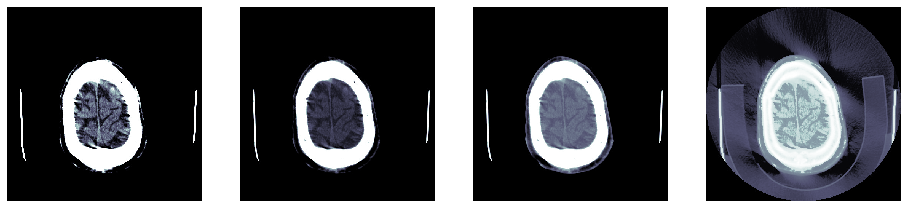

In [66]:
show_images(im.transpose(2,0,1))